# 03. Atmospheric maps from ERA5 atmospheric reanalysis
Data source:

DOI: 10.24381/cds.adbb2d47
<br>
Dataset is daily and hourly Jan 2024

## Import packages

In [49]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift

# ERA5
# from LIB_access_ERA5 import grab_ERA5

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Grab atmos. fields by date

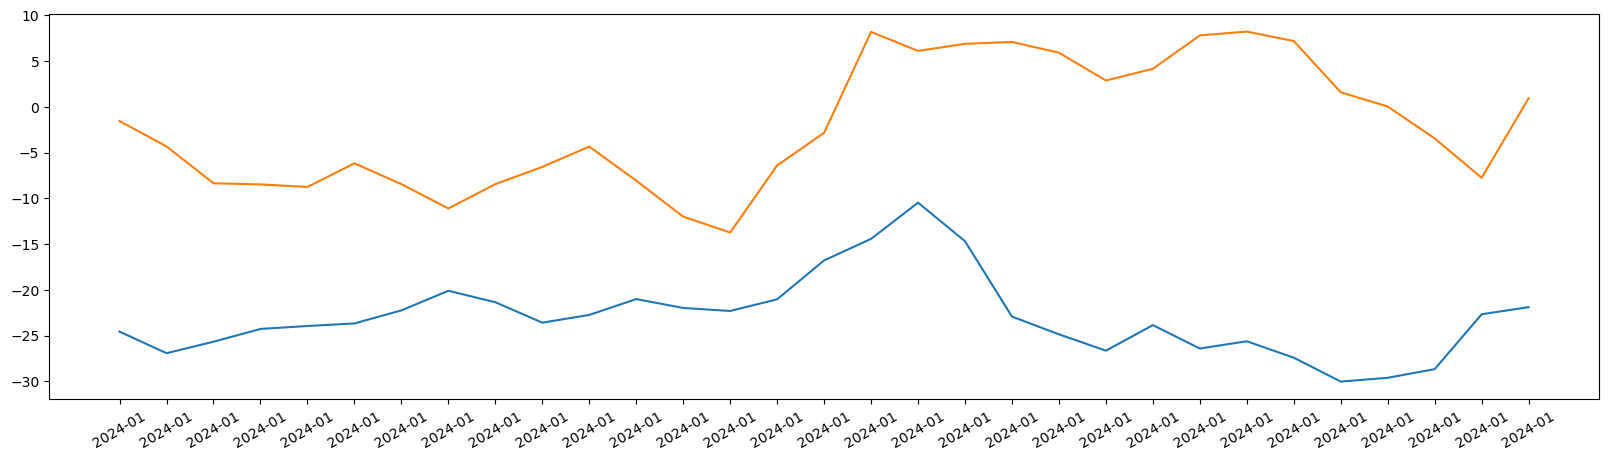

In [50]:

# specify date to import
#============================
date_list = pd.date_range(datetime(2024, 1, 1), datetime(2024, 1, 31)) #make this a date list
#============================

file_path = '/Volumes/Seagate2/Jan2024ERA5.nc'

ds = xr.load_dataset(file_path)
ds.close

#ds_date = ds.sel(time = date)

ERA5 = {}

ERA5['time'] = ds_date.time.values
ERA5['lon'] = ds_date.longitude.values
ERA5['lat'] = ds_date.latitude.values

ERA5['lon_grid'], ERA5['lat_grid'] = np.meshgrid(ERA5['lon'], ERA5['lat'])

ERA5['u10'] = ds_date.u10.values
ERA5['v10'] = ds_date.v10.values
ERA5['msl'] = ds_date.msl.values

#create empty 
u10_average = []
t2m_average = []
date_axs = []

for date in date_list:
    #subsetting data
    date_axs.append(date.to_pydatetime)
    ds_subset = ds.sel(longitude = slice(-153, -135), latitude = slice(73, 69), time = slice(date, date + timedelta(hours=23)))
    u10_average.append(ds_subset.mean(dim=("time", "latitude", "longitude")).u10.values)
    t2m_average.append((ds_subset.mean(dim=("time", "latitude", "longitude")).t2m.values)-273.15)

x = date_list
y = t2m_average
fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(x, y)
plt.plot(x, u10_average)
plt.xticks(rotation=30)
plt.xticks(date_list)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 


In [18]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -135.5 -135.2 -135.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 65.5 65.25 65.0
  * time       (time) datetime64[ns] 2024-01-01 ... 2024-01-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 -0.8739 -0.7221 ... 0.5935
    v10        (time, latitude, longitude) float32 0.7919 0.8024 ... 0.7484
    d2m        (time, latitude, longitude) float32 241.4 241.4 ... 246.3 246.7
    t2m        (time, latitude, longitude) float32 244.4 244.5 ... 249.4 249.8
    msl        (time, latitude, longitude) float32 1.036e+05 ... 1.01e+05
    sst        (time, latitude, longitude) float32 271.5 271.5 271.5 ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-10 21:05:57 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Make map

Text(0.05, -0.1, 'sea level pressure (hPa)')

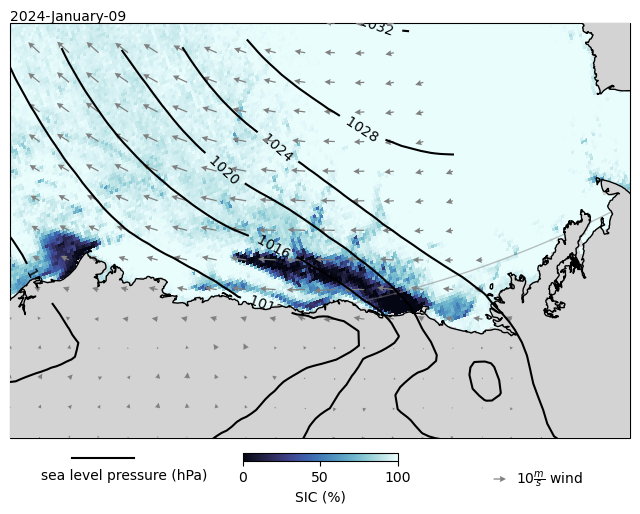

In [17]:

# specify date to plot SIC
#============================
date = datetime(2024, 1, 9)
#============================

# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
                main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                hemisphere='n', resolution='6250', version='v5.4', 
                return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                include_units=False, annual_folders=False, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# add land
add_land(ax, scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=5)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

#color bar
plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.25, pad=0.025)


# label date
ax.text(0, 1, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# ERA5 10m wind field
qv1 = ax.quiver(ERA5['lon_grid'], ERA5['lat_grid'], *fix_cartopy_vectors(ERA5['u10'], ERA5['v10'], ERA5['lat_grid']), 
                regrid_shape = 15, color = 'gray', width = 0.002, headwidth=5, scale = 500, transform = ccrs.PlateCarree(), zorder=5)
qk = ax.quiverkey(qv1, 0.8, -0.1, 10, r'$10 \frac{m}{s}$ wind', labelpos='E',transform=ccrs.PlateCarree())

# ERA5 mean sea level pressure
line_c = ax.contour(ERA5['lon_grid'], ERA5['lat_grid'], ERA5['msl']/100, 
           levels = np.arange(960,1080,4), colors='k', transform = ccrs.PlateCarree(), zorder=5)

# Use the line contours to place contour labels.
ax.clabel(line_c,  # Typically best results when labelling line contours.
          colors=['black'],
          manual=False,  # Automatic placement vs manual placement.
          inline=True,  # Cut the line where the label will be placed.
          fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
          zorder=4
         )

ax.plot([0.1,0.2], [-0.05, -0.05], clip_on=False, c='k', transform=ax.transAxes)
ax.text(0.05, -0.1, 'sea level pressure (hPa)', c='k', transform=ax.transAxes)


# plt.show()


# save figure, if desired
# save_path = f'/Users/jewell/Desktop/map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')